This notebook serves as an educational demonstration of exploratory statistical analysis and differental expression testing on RNA-seq expression data. More robust methods (DESeq2) are discussed in the README. 

Data Structure
-   Rows: genes (Ensembl IDs)
-   Columns: RNA-seq samples
-   Values: log2(FPKM + 1)
-   Experimental design: MBE.5 treatment vs DMSO control across multiple breast cancer cell lines

In [42]:
# Imports and processed Data
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel


In [43]:
# Checking current working directory
import os
print(os.getcwd())

/Users/maddi/Documents/secure_genomics_pipeline/notebooks


In [44]:
# Loading data, corrcting path
expr = pd.read_csv('../data/processed/log2_expression.csv', index_col=0)

print(expr.shape)
expr.head()

(25384, 8)


,r542,r543,r544,r545,r546,r547,r548,r549
gene_id,,,,,,,,
ENSG00000000003,3.675285,3.406300,1.641467,1.674768,3.745571,3.888178,2.970754,3.240835
ENSG00000000419,2.740416,2.729220,2.573326,2.293824,3.020075,2.868438,2.280380,2.607269
ENSG00000000457,1.224627,1.279424,1.139869,1.112066,1.226946,1.222298,1.108899,1.148029
ENSG00000000460,1.226570,1.203771,1.104625,1.106308,1.229865,1.230504,1.124818,1.154026
ENSG00000000971,1.000007,1.002213,1.081939,1.076080,1.006463,1.003919,1.073944,1.111632


In [45]:
# Building metadata manually 
expr.columns

Index(['r542', 'r543', 'r544', 'r545', 'r546', 'r547', 'r548', 'r549'], dtype='object')

Sample identifiers were mapped to GEO accessions using the series matrix file; internal sample IDs were retained for consistency

In [46]:
metadata = pd.DataFrame({
    'sample_id': expr.columns,
    'geo_accession': [
        'GSM8119803', 'GSM8119804', 'GSM8119805', 'GSM8119806',
        'GSM8119807', 'GSM8119808', 'GSM8119809', 'GSM8119810',
    ],
    'cell_line': [
        'HCC1937', 'HCC1937', 'SUM159-M1a-p44', 'SUM159-M1a-p44', 'MDA-468', 'MDA-468', '1833TR-p94', '1833TR-p94'
    ],
    'condition': ['DMSO control', 'MBE1.5 treated', 'DMSO control', 'MBE1.5 treated', 
                  'DMSO control', 'MBE1.5 treated', 'DMSO control', 'MBE1.5 treated'
    ]
}).set_index('sample_id')

print(expr.columns.tolist())
print()
print(metadata)

['r542', 'r543', 'r544', 'r545', 'r546', 'r547', 'r548', 'r549']

          geo_accession       cell_line       condition
sample_id                                              
r542         GSM8119803         HCC1937    DMSO control
r543         GSM8119804         HCC1937  MBE1.5 treated
r544         GSM8119805  SUM159-M1a-p44    DMSO control
r545         GSM8119806  SUM159-M1a-p44  MBE1.5 treated
r546         GSM8119807         MDA-468    DMSO control
r547         GSM8119808         MDA-468  MBE1.5 treated
r548         GSM8119809      1833TR-p94    DMSO control
r549         GSM8119810      1833TR-p94  MBE1.5 treated


In [47]:
# Checking alignment 
metadata.index.equals(expr.columns)

True

In [48]:
# Per-gene paired t-test across all cell lines
results = []

for gene in expr.index:
    treated = []
    control = []

    for cl in metadata['cell_line'].unique():
        sub = metadata[metadata['cell_line'] == cl]

        treated_sample = sub[sub['condition'] == 'MBE1.5 treated'].index[0]
        control_sample = sub[sub['condition'] == 'DMSO control'].index[0]

        treated.append(expr.loc[gene, treated_sample])
        control.append(expr.loc[gene, control_sample])

    stat, pval = ttest_rel(treated, control)
    log2fc = np.mean(treated) - np.mean(control)

    results.append([gene, log2fc, pval])


In [ ]:
# Build DE results table
de_results = pd.DataFrame(
    results, 
    columns=['gene_id', 'log2FC', 'pval']
)

de_results['adj_pval'] = (de_results['pval'].rank(method='min') / len(de_results))

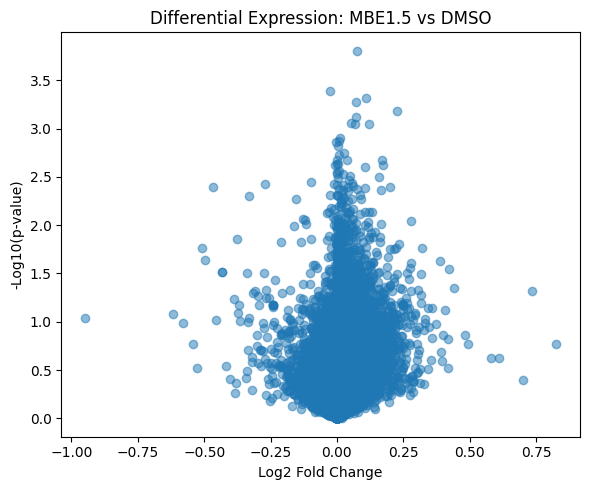

In [52]:
# Volcano plot
plt.figure(figsize=(6,5))
plt.scatter(
    de_results['log2FC'],
    -np.log10(de_results['pval']),
    alpha=0.5
)

plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10(p-value)')
plt.title('Differential Expression: MBE1.5 vs DMSO')
plt.tight_layout()